In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

/Users/Stefan/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Stefan/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
np.random.seed(42)

In [3]:
with pd.HDFStore('../../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [4]:
start = 1988
end = 2017

In [5]:
monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.columns.names = ['Ticker']
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 217 entries, MMM to XRX
dtypes: float64(217)
memory usage: 611.4 KB


## HRP Source

In [6]:
def get_inverse_var_pf(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [7]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

## Get Correlation Matrix

In [8]:
cov = monthly_returns.cov()
corr = monthly_returns.corr()
corr.columns.names=['Ticker']

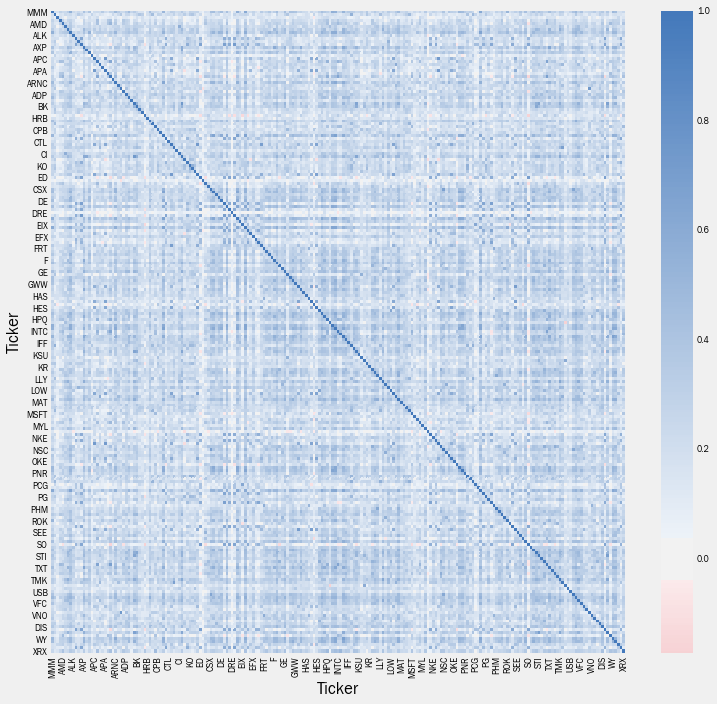

In [9]:
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()
fig.savefig('correl_map.png', dpi=600);


## Cluster Return Series

In [10]:
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [11]:
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')

In [12]:
sorted_idx = quasi_diagonalize(linkage_matrix)

### Plot Cluster Map

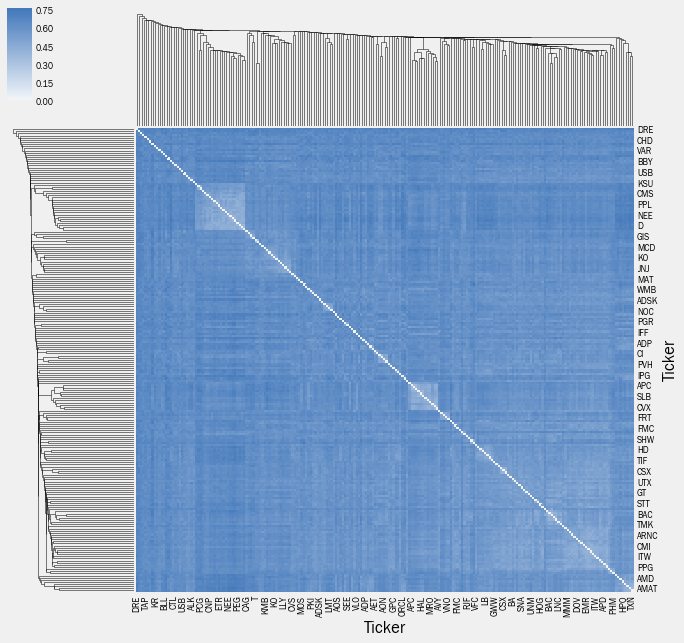

In [13]:
clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap, center=0);

In [14]:
clustergrid.savefig('clustermap.png', dpi=600)

In [15]:
sorted_idx = clustergrid.dendrogram_row.reordered_ind

In [16]:
sorted_tickers = corr.index[sorted_idx].tolist()

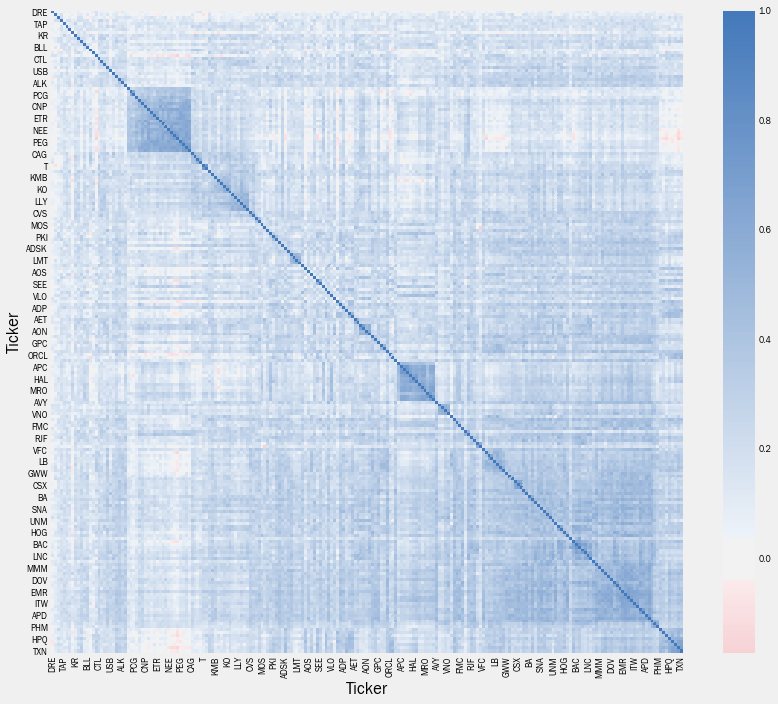

In [21]:
clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()
fig.savefig('corr_cluster', dpi=300);

## Compute Allocation

In [18]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_var_pf(cov_)
    return (w_ @ cov_ @ w_).item()

In [19]:
def get_hrp_allocation(cov, tickers):
    """Compute top-down HRP weights"""

    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]
        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)

            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

In [20]:
hrp_allocation = get_hrp_allocation(cov, sorted_tickers)

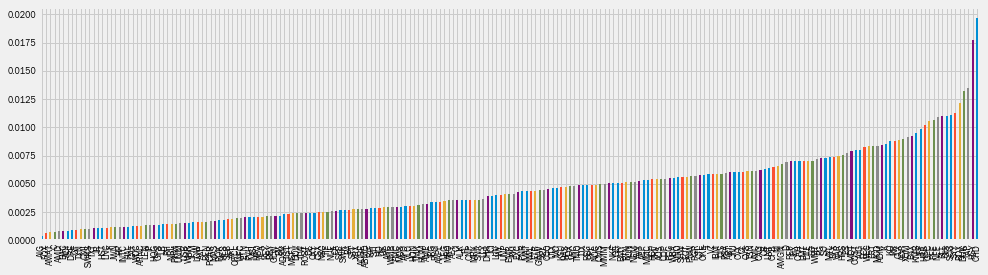

In [24]:
hrp_allocation.sort_values().plot.bar(figsize=(15,4));